In [22]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
from preprocessinganddata import ann_cparameters,load_classificationdata
from torch.utils.data import TensorDataset,DataLoader

In [23]:
X_train, y_train, X_val, X_test, y_val, y_test, num_classes = load_classificationdata()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test = np.concatenate((X_val, X_test), axis=0)
y_test = np.concatenate((y_val, y_test), axis=0)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
class CustomNeuralNetwork(torch.nn.Module):
    def __init__(self, layer_sizes):
        super(CustomNeuralNetwork, self).__init__()
        
        # Initialize weights (W) and biases (b) for each layer
        self.W = torch.nn.ParameterList()
        self.b = torch.nn.ParameterList()
        
        for i in range(len(layer_sizes) - 1):
            W_i = torch.nn.Parameter(torch.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01)
            b_i = torch.nn.Parameter(torch.zeros(layer_sizes[i + 1]))
            self.W.append(W_i)
            self.b.append(b_i)
        
        for i in range(len(self.W)):
            torch.nn.init.xavier_normal_(self.W[i])
    def forward(self, x):
        for i in range(len(self.W) - 1): 
            x = F.relu(torch.matmul(x, self.W[i]) + self.b[i])
        
        # Output layer (no activation function here as corss_entropy automatically apply softmax Okay)
        x = torch.matmul(x, self.W[-1]) + self.b[-1]
        return x
    
    def compute_loss(self, y_pred, y_true):
        return F.cross_entropy(y_pred, y_true)


In [25]:
def train_model(model, train_loader, epochs, learning_rate, optimizer_name='SGD', momentum=0.9):
    optimizer_map = {
        'SGD': torch.optim.SGD,
        'Adam': torch.optim.Adam,
        'RMSprop': torch.optim.RMSprop
    }
    
    if optimizer_name not in optimizer_map:
        raise ValueError(f"Invalid optimizer name '{optimizer_name}'. Choose from {list(optimizer_map.keys())}")
    
    if optimizer_name == 'SGD' or optimizer_name == 'RMSprop':
        optimizer = optimizer_map[optimizer_name](model.parameters(), lr=learning_rate, momentum=momentum)
    else:
        optimizer = optimizer_map[optimizer_name](model.parameters(), lr=learning_rate)
    
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            model.train()
            x = x.view(-1, 784)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            
            optimizer.zero_grad() 
            loss.backward()
            
            optimizer.step()
            
            total_loss += loss.item()
        
    return model , (total_loss / len(train_loader))

In [26]:
def grid_search(param_combinations , train_loader):
    best_loss = float('inf')
    best_config = None
    best_model = None
    for params in param_combinations:
        model = CustomNeuralNetwork(layer_sizes=params['layer_configs'])
        model , loss = train_model(model, train_loader, params['epochs'], params['learning_rates'], params['optimizers'])
        if loss < best_loss:
            best_loss = loss
            best_config = (params['layer_configs'], params['learning_rates'], params['optimizers'])
            best_model = model
        print(f"Layers: {params['layer_configs']}, LR: {params['learning_rates']}, Optimizer: {params['optimizers']}, Loss: {loss:.6f}")

    print("\nBest Configuration:")
    print(f"Layers: {best_config[0]}, Learning Rate: {best_config[1]}, Optimizer: {best_config[2]}")
    print(f"Best Loss: {best_loss:.6f}")
    
    return best_model, best_config

In [27]:
from itertools import product

param_grid = ann_cparameters()
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# best_model, best_config = grid_search(param_combinations , train_loader)

***I got the paraemters used below using grid search i am passing it manually as i do not want to run the grid search again and again so check the readme file and apply the parameters manually.***

In [38]:
model = CustomNeuralNetwork(layer_sizes=[784, 100, 60, 40, 10])
model , loss = train_model(model, train_loader, 50, 0.01 , 'Adam')
print(loss)

2.3567698154433208e-05


In [39]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.view(inputs.size(0), -1) 
            outputs = model(inputs) 
            _, predicted = torch.max(outputs, dim=1)
            
            labels = torch.argmax(labels, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total 
    return accuracy


In [40]:
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)

print(f'Training Accuracy: {train_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

Training Accuracy: 100.00%
Test Accuracy: 96.43%


In [41]:
torch.save(model.state_dict(), "classification_model")
print("Model saved successfully!")

Model saved successfully!


In [42]:
loaded_model = CustomNeuralNetwork([784, 120, 100, 60, 40, 10])
model.load_state_dict(torch.load("classification_model"))
model.eval()
print("Model Loaded")

Model Loaded


C:\Users\user\AppData\Local\Temp\ipykernel_9996\4267423735.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("classification_model"))


Training Data output


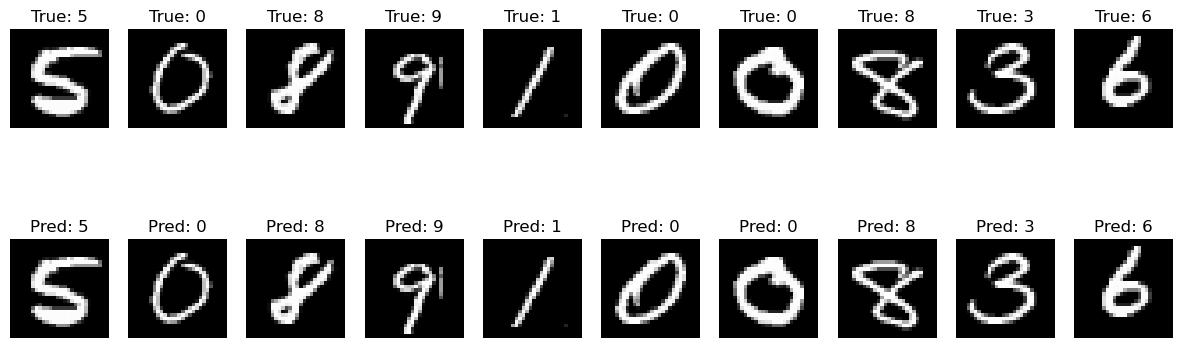

In [43]:
import matplotlib.pyplot as plt

# Evaluate model on test data and show actual vs predicted outputs
model.eval()  # Set model to evaluation mode
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Check if labels are one-hot encoded
if labels.ndimension() > 1:
    # If labels are one-hot encoded, convert to class indices
    labels = torch.argmax(labels, dim=1)

# Predict
images_flat = images.view(-1, 28 * 28)  # Flatten the images for the model input
outputs = model(images_flat)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(15, 5))  # Adjust figsize to better visualize images
for i in range(10):
    # Plot true labels
    plt.subplot(2, 10, i+1)
    plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(f"True: {labels[i].item()}")  # Ensure labels[i] is a scalar class index
    plt.axis('off')
    
    # Plot predicted labels
    plt.subplot(2, 10, i+11)
    plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted[i].item()}")  # Ensure predicted[i] is a scalar class index
    plt.axis('off')

print("Training Data output")
plt.show()


Testing Data output


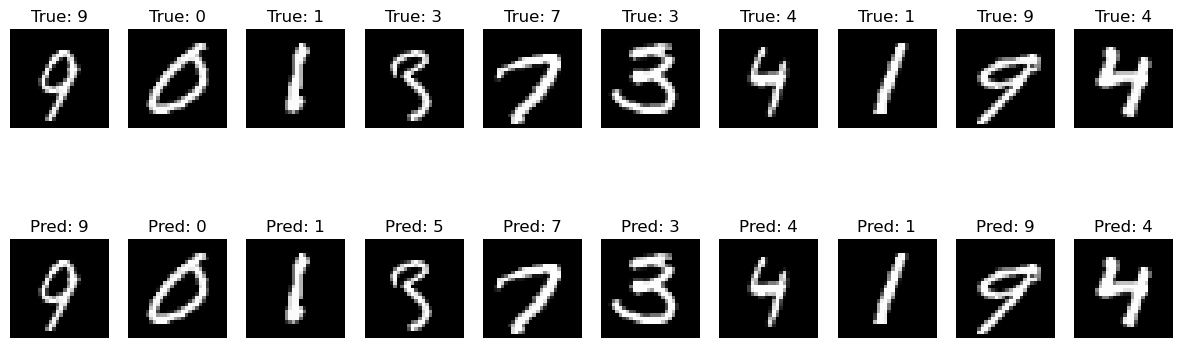

In [44]:
import matplotlib.pyplot as plt

# Evaluate model on test data and show actual vs predicted outputs
model.eval()  # Set model to evaluation mode
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Check if labels are one-hot encoded
if labels.ndimension() > 1:
    # If labels are one-hot encoded, convert to class indices
    labels = torch.argmax(labels, dim=1)

# Predict
images_flat = images.view(-1, 28 * 28)  # Flatten the images for the model input
outputs = model(images_flat)
_, predicted = torch.max(outputs, 1)

# Create a figure to display the images
fig = plt.figure(figsize=(15, 5))  # Adjust figsize to better visualize images
for i in range(10):
    # Plot true labels
    plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(f"True: {labels[i].item()}")  # Ensure labels[i] is a scalar class index
    plt.axis('off')
    
    # Plot predicted labels
    plt.subplot(2, 10, i + 11)
    plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted[i].item()}")  # Ensure predicted[i] is a scalar class index
    plt.axis('off')

# Show output
print("Testing Data output")
plt.show()